# Calculate the apparent Beta ratio

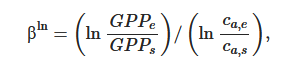

where GPPs and ca,s are of values in the starting year and GPPe and ca,e are of values in the ending year.

This metric does not isolate the CO2 induced response, but rather simply compares increasing GPP with increasing CO2


In [1]:
%matplotlib inline

import os
import sys
import pickle
import warnings
import scipy.stats
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from odc.geo.geom import Geometry
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import theilslopes, kendalltau
from xarrayMannKendall import Mann_Kendall_test

sys.path.append('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/src')
from analysis import mk_with_slopes
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords

Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead


## Analysis Parameters

In [2]:
model_var='GPP'
path = '/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/AusEFlux_versions/AusEFlux_GPP_5km_1982_2022_v0.4.nc'
# path = '/g/data/os22/chad_tmp/Aus_CO2_fertilisation/notebooks/upscale_GPP/data/5km/fPAR_5km_monthly_1982_2022.nc'

covar_file = f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/covars.nc'

## Open data

and aggregate to annual

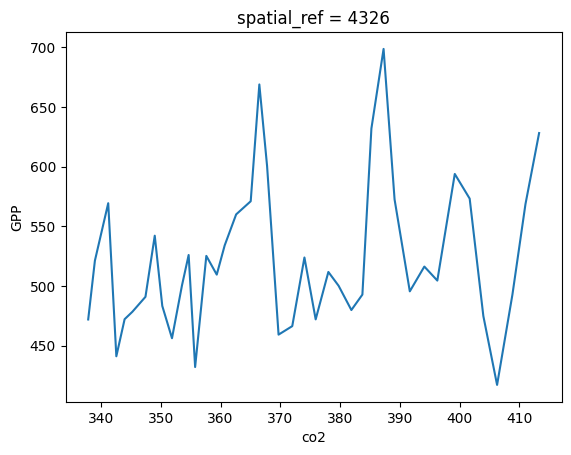

In [3]:
gpp = assign_crs(xr.open_dataset(path), crs='EPSG:4326')
mask = ~np.isnan(gpp.mean('time'))
gpp = gpp.groupby('time.year').sum().where(mask)

co2 = xr.open_dataset(covar_file)['co2'].mean(['latitude', 'longitude'])
co2 = co2.groupby('time.year').mean()

gpp['year'] = co2 #replace year with co2 values
gpp = gpp[model_var].rename({'year':'co2'})

gpp.mean(['latitude', 'longitude']).plot()

## Compute trends in GPP as a function of CO2

In [4]:
out = xr.apply_ufunc(mk_with_slopes,
              gpp,
              input_core_dims=[["co2"]],
              output_core_dims=[[],[],[],],
              vectorize=True
                    )

p = out[0].rename('p_value')
s = out[1].rename('slope')
i = out[2].rename('intercept')

All-NaN slice encountered
Mean of empty slice.
invalid value encountered in double_scalars


## Calculate apparent beta

We will use the first and last predictions of the a linear prediction rather than the actual time-series of GPP to remove the inflluence of IAV

In [5]:
#reopen the griddded CO2 values
co2_ds = xr.open_dataset(covar_file)['co2']
co2_ds = co2_ds.groupby('time.year').mean()

# now calculate GPP predicted from the linear equation
y = s * co2_ds + i 
y['year'] = co2 #replace year with co2 values
y = y.rename({'year':'co2'})

In [6]:
# (gpp.isel(co2=range(-5,0)).mean('co2') - gpp.isel(co2=range(0,5)).mean('co2')).plot(robust=True, cmap='BrBG')
# (y.isel(co2=range(-5,0)).mean('co2') - y.isel(co2=range(0,5)).mean('co2')).plot(robust=True, cmap='BrBG')

In [7]:
#use the first and last values of gpp-predicted to calculate B-apparent
gppt1=y.isel(co2=-1)
gppt0=y.isel(co2=0)

cat1=co2_ds.isel(year=-1)
cat0=co2_ds.isel(year=0)

beta_apparent_ratio = (np.log(gppt1 / gppt0)) / (np.log(cat1 / cat0))

#Alternate approach
# gppt1=gpp.isel(co2=range(-5,0)).mean('co2')
# gppt0=gpp.isel(co2=range(0,5)).mean('co2')

# cat1=co2_ds.isel(year=range(-5,0)).mean('year')
# cat0=co2_ds.isel(year=range(0,5)).mean('year')
# beta_apparent_ratio = ((gppt1-gppt0)/gppt0) / ((cat1-cat0)/cat0)


invalid value encountered in log


## Masking

In [8]:
#positive slope mask
positive_mask = ~np.isnan(s.where(s>0))

# NDVI data for masking very low ndvi areas
ds_path = f'/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022_0.2.0.nc'
ds = assign_crs(xr.open_dataset(ds_path), crs='EPSG:4326')
ds = ds.rename({'AusENDVI_clim_MCD43A4':'NDVI'})
ds = ds['NDVI'].mean('time')
low_ndvi = xr.where(ds<0.10, 1, 0)

crops = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/croplands_5km.nc')['croplands']
crops = xr.where(crops==1, 0, 1) #irrigated crops
crops = round_coords(crops)

urban = xr.open_dataarray('/g/data/xc0/project/AusEFlux/data/urban_water_mask_5km.nc')
mask = (urban | crops)

mask = ~mask.astype('bool')

beta_apparent_ratio = beta_apparent_ratio.where(positive_mask)
beta_apparent_ratio = beta_apparent_ratio.where(~low_ndvi)
beta_apparent_ratio = beta_apparent_ratio.where(mask)

### Plot

In [9]:
#remove any infs
beta_apparent_ratio = beta_apparent_ratio.where(~np.isinf(beta_apparent_ratio))

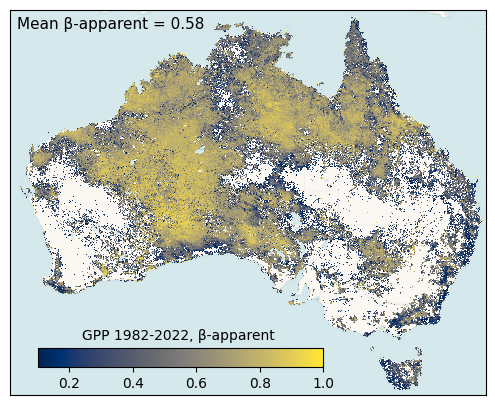

In [10]:
fig,ax = plt.subplots(1,1, figsize=(7,5))
im = beta_apparent_ratio.plot(ax=ax, add_labels=False,  vmin=0.1, vmax=1.0, cmap='cividis', add_colorbar=False)

ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
# ax[0].set_title(f'\u03B2, {data_product}')
axins1 = inset_axes(ax, width="60%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
cbar.ax.set_title(f'{model_var} 1982-2022, \u03B2-apparent ', fontsize=10);

ax.text(0.015, 0.95, f'Mean \u03B2-apparent = {beta_apparent_ratio.mean().item():.2f}',  transform=ax.transAxes, fontsize=11);

fig.savefig(f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/Beta_apparent_{model_var}.png',
            bbox_inches='tight', dpi=300)

## Mask to forests only

In [11]:
lc = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/ESA_WorldCover_processed.nc').drop_vars('band')
tree_mask = xr.where(lc==1, 1, 0)

In [12]:
tree_beta_apparent_ratio = beta_apparent_ratio.where(tree_mask)

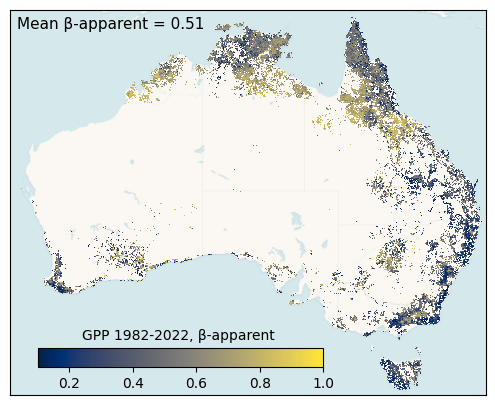

In [13]:
fig,ax = plt.subplots(1,1, figsize=(7,5))
im = tree_beta_apparent_ratio.plot(ax=ax, add_labels=False,  vmin=0.1, vmax=1.0, cmap='cividis', add_colorbar=False)

ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
# ax[0].set_title(f'\u03B2, {data_product}')
axins1 = inset_axes(ax, width="60%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
cbar.ax.set_title(f'{model_var} 1982-2022, \u03B2-apparent ', fontsize=10);

ax.text(0.015, 0.95, f'Mean \u03B2-apparent = {tree_beta_apparent_ratio.mean().item():.2f}',  transform=ax.transAxes, fontsize=11);

# fig.savefig(f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/Beta_apparent_{model_var}.png',
#             bbox_inches='tight', dpi=300)